## Vanishing/exploding gradients problem

In [36]:
def logit(z):
    return 1/ (1 + np.exp(-z))

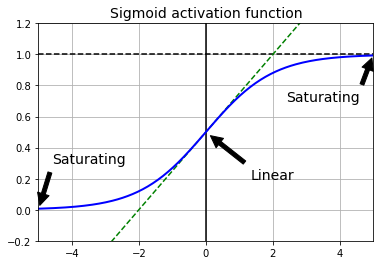

In [38]:
import numpy as np
import matplotlib.pyplot as plt

z = np.linspace(-5,5,200)

plt.plot([-5,-5], [0,0], 'k-')
plt.plot([-5,5], [1,1], 'k--')
plt.plot([0,0], [-0.2,1.2], 'k-')
plt.plot([-5,5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), 'b-', linewidth=2)
props= dict(facecolor='black',shrink=0.1)

plt.annotate('Saturating', xytext=(3.5,0.7), xy=(5,1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5,0.3), xy=(-5,0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5),arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

### Xavier and He Initialisation

In [3]:
# The book uses fully_connected isntaead of dense but it is preferable to use dense

import tensorflow as tf

#reset_graph()
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

n_inputs = 28 *28
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [4]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

W0528 07:00:28.203332 16044 deprecation.py:323] From <ipython-input-4-da109dac52d3>:3: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


### Non Saturating Activation function

In [5]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

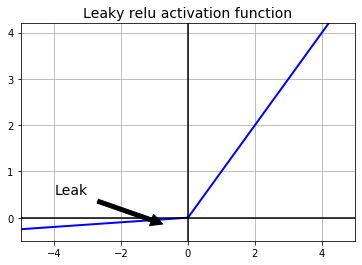

In [6]:
# plotting leaky relu

plt.plot(z, leaky_relu(z, 0.05), "b-",linewidth=2)
plt.plot([-5,5],[0,0], 'k-')
plt.plot([0,0], [-0.5, 4.2],'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)

plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-0.5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky relu activation function", fontsize=14)
plt.axis([-5,5,-0.5,4.2])

plt.show()

### Implementing leaky relu in tensorflow

In [7]:
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

X = tf.placeholder(tf.float32, shape=(None, n_inputs),name="X")

In [8]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

W0528 07:00:28.591204 16044 deprecation.py:506] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [10]:
X = tf.placeholder(tf.float32,shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [11]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [12]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [13]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

W0528 07:00:28.766730 16044 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [15]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [21]:
# loading the dataset tf.examples.tutorials.mnist is depreciated

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1,28 *28)/ 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28)/ 255.0

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [19]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [18]:
n_epochs = 40
batch_size =50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
            acc_valid = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
            print(epoch, acc_batch, acc_valid)
    
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 0.86 0.9048
5 0.94 0.9496
10 0.92 0.9656
15 0.94 0.971
20 1.0 0.976
25 1.0 0.9778
30 0.98 0.978
35 1.0 0.9786


### ELU function

In [19]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

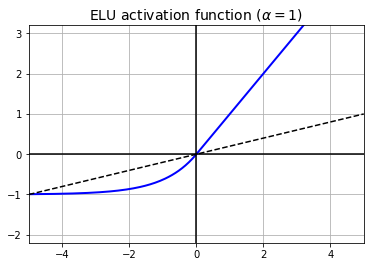

In [20]:
plt.plot(z, elu(z),"b-", linewidth=2)
plt.plot([-5,5], [0,0], 'k-')
plt.plot([-5,5], [-1,1], 'k--')
plt.plot([0,0], [-2.2,3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5,5,-2.2,3.2])

plt.show()

In [2]:
import tensorflow as tf
import numpy as np

def reset_graph():

    tf.reset_default_graph()
    tf.set_random_seed(42)
    np.random.seed(42)

In [22]:
# implementing ELU in tensorflow
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [23]:
hidden1 = tf.layers.dense(X, n_hidden1,activation=tf.nn.elu, name="hidden1")

### SELU

In [24]:
# this function tends to preserve the mean and variance during training
# In practice it works very well with CNN

from scipy.special import erfc

alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [27]:
def selu(z, scale=scale_0_1,alpha=alpha_0_1):
    return scale * elu(z, alpha)

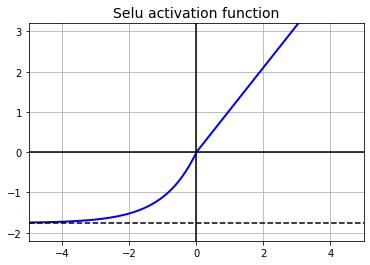

In [28]:
import matplotlib.pyplot as plt

z = np.linspace(-5,5,200)

plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5,5], [0,0], 'k-')
plt.plot([-5,5], [-1.758, -1.758], 'k--')
plt.plot([0,0], [-2.2,3.2], 'k-')
plt.grid(True)
plt.title("Selu activation function", fontsize=14)
plt.axis([-5, 5,-2.2,3.2])
plt.show()

# the selu function hyperparameters are tuned in such a way that mean output of each
# neiron remains close to 0 
# and the standrd deviation remains close to 1
# even if therewere about 1000 layers

In [29]:
# we can verify fir 1000 layers
np.random.seed(42)
Z = np.random.normal(size=(500,100))
for layer in range(1000):
    W = np.random.normal(size=(100,100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print(layer, means,stds)

0 -0.0018323191229082014 0.9993326848140984
100 0.022381401728658136 0.9624307594850072
200 0.009595136169400975 0.9044881262732755
300 -0.01519457019486652 0.9236924543338241
400 0.0541343380033697 0.8916028369516269
500 0.005853113458524639 0.9286462949083308
600 0.022268641456820597 0.9166416040576405
700 -0.01825907594144632 0.9033554369309249
800 0.053814955568643616 0.8250223490618902
900 0.01989578336047298 0.9952796987739755


In [1]:
# reset_graph()

# n_inputs = 28 * 28  # MNIST
# n_hidden1 = 300
# n_hidden2 = 100
# n_outputs = 10

# X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
# y = tf.placeholder(tf.int32, shape=(None), name="y")

# with tf.name_scope("dnn"):
#     hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
#     hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
#     logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

# with tf.name_scope("loss"):
#     xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
#     loss = tf.reduce_mean(xentropy, name="loss")

# learning_rate = 0.01

# with tf.name_scope("train"):
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#     training_op = optimizer.minimize(loss)

# with tf.name_scope("eval"):
#     correct = tf.nn.in_top_k(logits, y, 1)
#     accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

# init = tf.global_variables_initializer()
# saver = tf.train.Saver()
# n_epochs = 40
# batch_size = 50

# # some error


### Batch Normalisation

In [31]:
import tensorflow as tf
import numpy as np

reset_graph()

from tensorflow.contrib.layers import batch_norm

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None,n_inputs), name="X")

# decay is renamed as momentum
# is_training parameter would either be true or false
# tells what means to be used in testing ans trainaing phase
# in testing we need to use the entire dataset mean and standard deviation

#is_training = tf.placeholder(tf.bool,shape=(), name="is training")

training = tf.placeholder_with_default(False, shape=(), name='training')

# bn_params is a dictionary that defines the parameters that will be passed to batch norm()
# algorithm uses exponential decay to compute the running averages
# a good decay is close to one
# Update collection to be set to None if we want the batch_norm()
# function to update the running averages right before it perform
#batch normalisation during training

# bn_params = {
#     "is_training" : is_training,
#     "decay": 0.99,
#     "updates_collections": None
# }

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.90)  
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2,name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training, momentum=0.9)

# normalizer_fn = batch_norm, normalizer_params=bn_params)
# hidden2 = dense(hidden1, n_hidden2 , scope="hidden2",
#                 normalizer_fn =batch_norm, normalizer_paramas=bn_params)
# logits = dense(hidden2, n_outputs,activation_fn=None, scope="outputs",
#                normalizer_fn =batch_norm, normalizer_params=bn_params)



W0528 07:04:49.620287 16044 deprecation.py:323] From <ipython-input-31-dd5d141516b5>:38: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


In [32]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None,n_inputs), name="X")
training = tf.placeholder_with_default(False,shape=(), name="training")

In [33]:
# to avoid repeating the same function again and again we can call the partil function

from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=0.90)

hidden1 = tf.layers.dense(X,n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act,n_hidden2,name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

In [37]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [38]:
n_epochs = 20
batch_szie = 200

In [39]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training:True, X:X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
        print(epoch, "Validation accuracy: ", accuracy_val)
    save_path = saver.save(sess, "./my_model_final.ckpt")

# its not great accuracy for mnist
# butwe can get better result if we train it for longer


0 Validation accuracy:  0.9342
1 Validation accuracy:  0.9556
2 Validation accuracy:  0.9604
3 Validation accuracy:  0.969
4 Validation accuracy:  0.9714
5 Validation accuracy:  0.9736
6 Validation accuracy:  0.9746
7 Validation accuracy:  0.9744
8 Validation accuracy:  0.9768
9 Validation accuracy:  0.979
10 Validation accuracy:  0.9774
11 Validation accuracy:  0.9786
12 Validation accuracy:  0.978
13 Validation accuracy:  0.9772
14 Validation accuracy:  0.9798
15 Validation accuracy:  0.9792
16 Validation accuracy:  0.9798
17 Validation accuracy:  0.9798
18 Validation accuracy:  0.9792
19 Validation accuracy:  0.9804


In [40]:
# we can make the training operation depend on the update operations
# with tf.name_scope("Train"):
#  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#  extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# with tf.control_dependencies(extra_update_ops):
#  training_op = optimizer.minimize(loss)
# the during sess.run when training_op is called the tensorflow will aitomatically run update as well

#looking at the trainable variable

[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [41]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

### Gradient clipping for MNIST

In [43]:
reset_graph()


# we are using extra layers to demonstrate using pretrained models
n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    

In [25]:
learning_rate =0.01

In [45]:
# we apply clip by value()

threshold = 1.0
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var) for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [46]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k (logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32),name="accuracy" )

In [48]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [49]:
n_epochs = 20
batch_Size =200

In [50]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
        print(epoch, "validation accuracy: ", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 validation accuracy:  0.8768
1 validation accuracy:  0.928
2 validation accuracy:  0.9458
3 validation accuracy:  0.9544
4 validation accuracy:  0.9572
5 validation accuracy:  0.9562
6 validation accuracy:  0.967
7 validation accuracy:  0.9712
8 validation accuracy:  0.9676
9 validation accuracy:  0.9724
10 validation accuracy:  0.9752
11 validation accuracy:  0.9734
12 validation accuracy:  0.9698
13 validation accuracy:  0.973
14 validation accuracy:  0.9764
15 validation accuracy:  0.9754
16 validation accuracy:  0.9764
17 validation accuracy:  0.9764
18 validation accuracy:  0.9772
19 validation accuracy:  0.9736


### Reusing a TensorFlow model

In [3]:
reset_graph()

In [5]:

# we will first load the meta file

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

In [6]:
# we need a handle on all the operations we need for the training.

for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

In [8]:
#from tensorflow_graph_in_jupyter import show_graph
# need to define this firts

In [9]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")
training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

In [12]:
# another approach
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops",op)

In [13]:
# such that
X,y, accuracy,training_op=tf.get_collection("my_important_ops")

In [15]:
# starting a session
# restoring model state 
# training on our data

with tf.Session() as sess:
    saver.restore(sess, "my_model_final.ckpt")

In [23]:
# testing

n_epochs = 20
batch_size =200

with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch, in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
        print(epoch, "validation accuracy", accuracy_val)
    
    save_path = saver.save(sess, "./my_new_model_final.ckpt")

0 validation accuracy 0.979
1 validation accuracy 0.979
2 validation accuracy 0.978
3 validation accuracy 0.9798
4 validation accuracy 0.979
5 validation accuracy 0.9788
6 validation accuracy 0.9782
7 validation accuracy 0.9782
8 validation accuracy 0.979
9 validation accuracy 0.9784
10 validation accuracy 0.9784
11 validation accuracy 0.9792
12 validation accuracy 0.9778
13 validation accuracy 0.9778
14 validation accuracy 0.9788
15 validation accuracy 0.979
16 validation accuracy 0.9788
17 validation accuracy 0.979
18 validation accuracy 0.978
19 validation accuracy 0.9784


In [26]:
# now we need to reuse only the lower layers
# in this example we add a new 4th layer on top of a third layer
#we will also build a new output layer the loss of this new output and an optimiser to minimise it
# and then we save the new graph and an initilisation up

reset_graph()

n_hidden4 = 20
n_outputs = 10

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits,y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [30]:
# training the new model

with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch,y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
        print(epoch, "Validation accuracy: ", accuracy_val)
        
        save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

0 Validation accuracy:  0.9434
1 Validation accuracy:  0.9606
2 Validation accuracy:  0.9668
3 Validation accuracy:  0.9684
4 Validation accuracy:  0.9722
5 Validation accuracy:  0.9724
6 Validation accuracy:  0.9722
7 Validation accuracy:  0.9728
8 Validation accuracy:  0.974
9 Validation accuracy:  0.974
10 Validation accuracy:  0.9754
11 Validation accuracy:  0.9746
12 Validation accuracy:  0.976
13 Validation accuracy:  0.9764
14 Validation accuracy:  0.9772
15 Validation accuracy:  0.976
16 Validation accuracy:  0.9762
17 Validation accuracy:  0.976
18 Validation accuracy:  0.9756
19 Validation accuracy:  0.9752


In [33]:
# we can reuse the parts we need in the old python code
reset_graph()

n_inputs = 28 * 28 #MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 20
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    logits = tf.layers.dense(hidden4,n_outputs, name="outputs") 

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss = tf.reduce_mean(xentropy,name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [35]:
# we have to create one Saver to restore the pretrained moodel
# and another saver for new model

reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]")# regex to get layers 1 to 3
restore_saver = tf.train.Saver(reuse_vars) # restore layer 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict = {X:X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
        print(epoch, "Validation accuracy: ", accuracy_val)
    save_path = saver.save(sess, "./my_new_model_final.ckpt")

0 Validation accuracy:  0.9278
1 Validation accuracy:  0.9496
2 Validation accuracy:  0.9576
3 Validation accuracy:  0.9646
4 Validation accuracy:  0.968
5 Validation accuracy:  0.9698
6 Validation accuracy:  0.9722
7 Validation accuracy:  0.973
8 Validation accuracy:  0.9744
9 Validation accuracy:  0.975
10 Validation accuracy:  0.9754
11 Validation accuracy:  0.9766
12 Validation accuracy:  0.9736
13 Validation accuracy:  0.9762
14 Validation accuracy:  0.9768
15 Validation accuracy:  0.9764
16 Validation accuracy:  0.9768
17 Validation accuracy:  0.9772
18 Validation accuracy:  0.9782
19 Validation accuracy:  0.9776


### Reusing models from other frameworks

In [40]:
# following code shows how you would copy the weight and biases from the 
# first hidden layer of  a model tranined using another framework

reset_graph()
n_inputs = 2
n_hidden1 = 3

In [41]:
original_w = [[1.,2.,3.], [4.,5.,6.]] # weights from the other framework
original_b = [7.,8.,9.] # loading the biases fromother frameworks

X= tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")

graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel:original_w, init_bias: original_b})
    print(hidden1.eval(feed_dict={X: [[10.0,11.0]]}))
    

[[ 61.  83. 105.]]


In [46]:
# the book uses a more verbose version

reset_graph()

n_inputs =2
n_hidden1 = 3

original_w = [[1.,2.,3.], [4.,5.,6.]]
original_b = [7.,8.,9.]

X = tf.placeholder(tf.float32, shape=(None, n_inputs),name="X")
hidden1 = tf.layers.dense(X, n_hidden1,activation=tf.nn.relu, name="hidden1")


with tf.variable_scope("", default_name="", reuse=True):
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# creating dedicated placeholder and assignment nodes
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights,feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    print(hidden1.eval(feed_dict={X: [[10.0,11.0]]}))
    

[[ 61.  83. 105.]]


In [47]:
# we could have gtten the handle iusin getcollection and specifying scope
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")


[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

In [48]:
#or the get_tensor_by_name() method
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [49]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>